In [ ]:
!pip install -U sentence-transformers
!pip install umap-learn
!pip install umap-learn[plot]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 71.1 MB/s eta 0:00:00


In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from sentence_transformers import SentenceTransformer
import numpy as np
import umap
from sklearn.cluster import KMeans
import umap.plot
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

from sklearn.preprocessing import MaxAbsScaler

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

'''
Variables:
---------

corpus : list of documents
embeddings : documents embeddings of size NxM (N : number of documents, M : embedding dimension)
red_emd : reduced embeddings matrix using dimentionality reduction
k : number of clusters
labels : documents labels
pred : list of clustering predicted clusters

''';

In [ ]:
def dim_red(mat, p):
    '''
    Perform dimensionality reduction

    Input:
    -----
        mat : NxM list
        p : number of dimensions to keep
    Output:
    ------
        red_mat : NxP list such that p<<m
    '''
    category_labels = [ng20.target_names[x] for x in ng20.target]
    hover_df = pd.DataFrame(category_labels, columns=['category'])
    hover_df = hover_df[:2000]

    vectorizer = CountVectorizer(min_df=5, stop_words='english')
    word_doc_matrix = vectorizer.fit_transform(corpus)

    #reducer = umap.UMAP(n_components=p)
    reducer = umap.UMAP(n_components=2, metric='correlation').fit(word_doc_matrix)
    red_mat = reducer.fit_transform(mat)

    #mapper = umap.UMAP().fit(mat)
    #umap.plot.points(mapper, labels=labels)
    f = umap.plot.points(reducer, labels=hover_df['category'], width = 1000, height = 1000)



    return red_mat

In [ ]:
def clust(mat, k):
    '''
    Perform clustering

    Input:
    -----
        mat : input list
        k : number of cluster
    Output:
    ------
        pred : list of predicted labels
    '''
    kmeans = KMeans(n_clusters=k, random_state=42)  # You can adjust the random_state as needed
    pred = kmeans.fit_predict(mat)

    plt.figure()
    colors = plt.cm.get_cmap('tab10', k)  # You can choose a different colormap if needed
    cluster_cmap = ListedColormap(colors(range(k)))

    # Plot UMAP results with distinct colors for each cluster
    plt.scatter(mat[:, 0], mat[:, 1], c=pred, cmap=cluster_cmap, s=10)  # Adjust size as needed
    plt.title(f'Visualization with KMeans Clustering (p={pred}, k={k})')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

    centroids = kmeans.cluster_centers_

    plt.figure()
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=100, label='Centroids')  # Adjust color and size as needed

    plt.title(f'Centroids Visualization with KMeans Clustering (p={pred}, k={k})')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.show()

    return pred

In [ ]:
# import data
ng20 = fetch_20newsgroups(subset='test')
corpus = ng20.data[:2000]
labels = ng20.target[:2000]
k = len(set(labels))

# embedding
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embeddings = model.encode(corpus)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-89-c389295ca333>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', k)  # You can choose a different colormap if needed


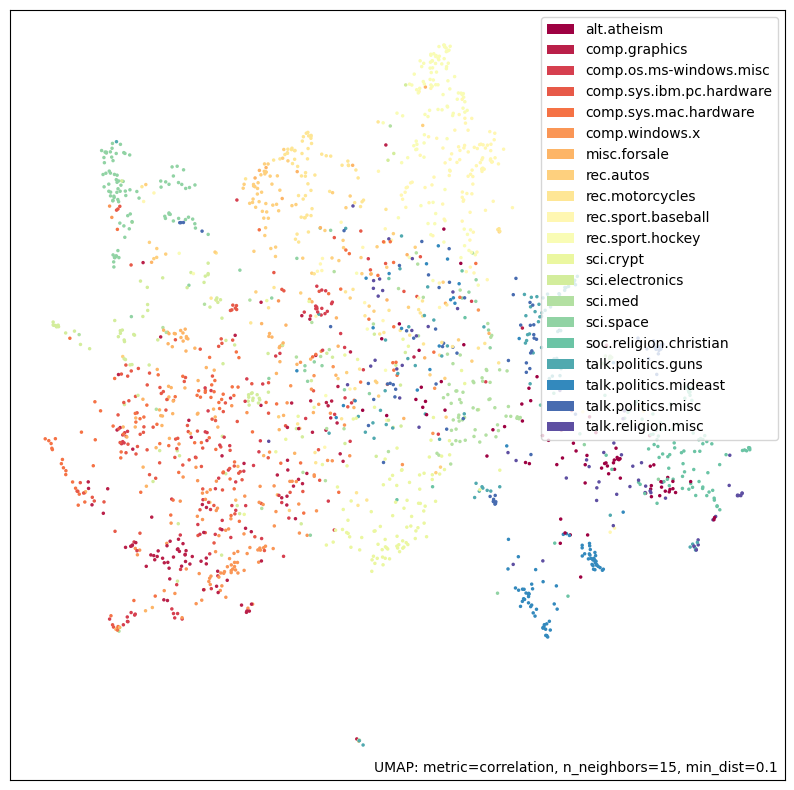

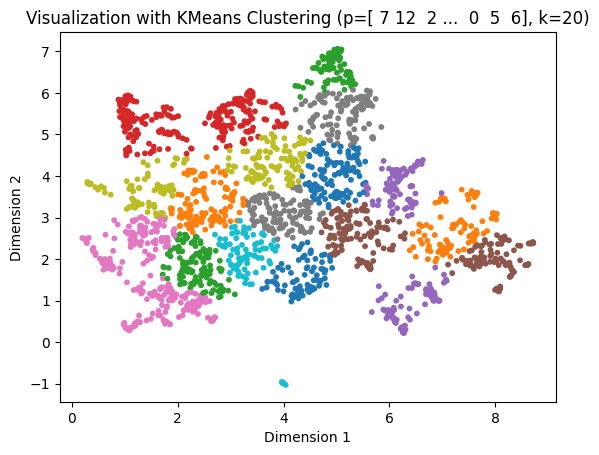

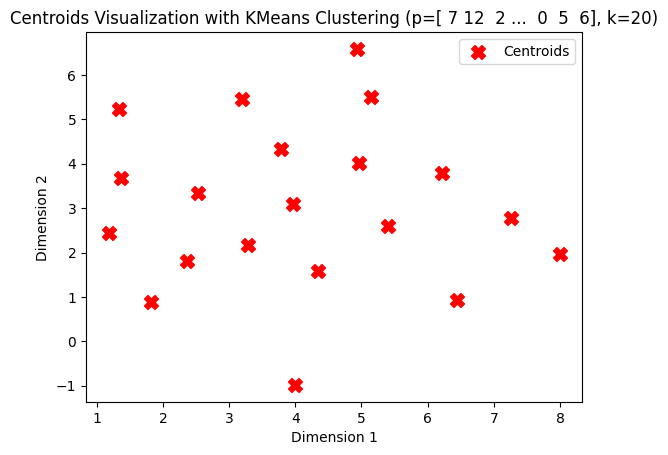

NMI: 0.47 
ARI: 0.28


In [ ]:
# perform dimentionality reduction
red_emb = dim_red(embeddings, 20)

# perform clustering
pred = clust(red_emb, k)

# evaluate clustering results
nmi_score = normalized_mutual_info_score(pred,labels)
ari_score = adjusted_rand_score(pred,labels)

print(f'NMI: {nmi_score:.2f} \nARI: {ari_score:.2f}')


In [ ]:
def cross_validate_reduction(red_emb, X, y, n_components=2):
    reduced_X = red_emb
    clf = RandomForestClassifier()
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, reduced_X, y, cv=cv, scoring='accuracy')
    return scores

# reduce_with_X = red_emb with method X
umap_scores = cross_validate_reduction(red_emb, corpus, labels)
#pca_scores = cross_validate_reduction(red_emb, corpus, labels)
#tsne_scores = cross_validate_reduction(red_emb, corpus, labels)

print("UMAP Scores:", umap_scores)
#print("PCA Scores:", pca_scores)
#print("t-SNE Scores:", tsne_scores)

UMAP Scores: [0.535  0.5875 0.535  0.575  0.5275]
